# **Clustering de pays asiatiques sur la gestion de la pandémie de COVID 19**

In [5]:
# Chargement des principales librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')

## **A propos du jeu de données** :

Le jeu de données collecté sur https://www.worldometers.info/coronavirus/#countries contient des statistiques pays par pays sur la pandémie du Covid et inclut les variables suivantes :

| Variable                | Description                                                  |
|-------------------------|--------------------------------------------------------------|
| **ID**                  | Identifiant unique                                           |
| **Country**             | Nom du pays                                                  |
| **TotalCases**          | Nombre total de cas enregistrés au moment de la collecte     |
| **TotalDeaths**         | Nombre total de décès enregistrés au moment de la collecte   |
| **TotalRecovered**      | Nombre de personnes guéries                                 |
| **ActiveCases**         | Nombre de personnes atteintes du virus au moment de la collecte |
| **TotalCasesPerMillion**| Nombre de cas enregistrés par million d’habitants            |
| **TotalDeathsPerMillion**| Nombre de décès enregistrés par million d’habitants         |
| **TotalTests**          | Nombre total de tests COVID-19 effectués (RTPCR + RAT + autres tests) |
| **TotalTestsPerMillion**| Nombre de tests effectués par million d’habitants            |
| **TotalPopulation**     | Population totale du pays                                    |


## **0. Importation de la base**

In [6]:
data = pd.read_csv("../data/CovidCases.csv", sep = ";", index_col = "ID" )
data.head()

,Country,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,TotalCasesPerMillion,TotalDeathsPerMillion,TotalTests,TotalTestsPerMillion,TotalPopulation
ID,,,,,,,,,,
1,Yemen,9369,1778.0,5921,1670,306,58.0,265253.0,8651.0,30660443
2,Vietnam,839662,20555.0,782199,36908,8529,209.0,42517091.0,431850.0,98453377
3,Uzbekistan,178637,1271.0,174213,3153,5241,37.0,1377915.0,40425.0,34086135
4,UAE,737890,2114.0,731295,4481,73477,211.0,87246490.0,8687776.0,10042442
5,Turkey,7444552,66180.0,6893476,484896,87077,774.0,89847975.0,1050928.0,85493959


In [7]:
data.shape

(49, 10)

La base de données comprend 49 observations et 9 variables quantitatives et une variable qualitative (Country). 

## **1. Exploration du jeu de données**


### **1.1. Gestion des valeurs manquantes**

In [8]:
data.isna().sum()

Country                  0
TotalCases               0
TotalDeaths              1
TotalRecovered           0
ActiveCases              0
TotalCasesPerMillion     0
TotalDeathsPerMillion    1
TotalTests               1
TotalTestsPerMillion     1
TotalPopulation          0
dtype: int64

In [9]:
data.loc[(data.loc[:, ["TotalTestsPerMillion", "TotalDeathsPerMillion"]].isna()).any(axis=1), ["Country", "TotalTests", "TotalTestsPerMillion", "TotalDeaths", "TotalDeathsPerMillion"]]

,Country,TotalTests,TotalTestsPerMillion,TotalDeaths,TotalDeathsPerMillion
ID,,,,,
8,Tajikistan,NaN,NaN,124.0,13.0
25,Macao,4951.0,7495.0,NaN,NaN


On note quatre valeurs manquantes dans la base de données correspondant à deux pays que nous allons imputer. 

**Les variables TotalTestsPerMillion et TotalTests**

Pour imputer les valeurs manquantes de ces variables, notre intuition a été d’établir un lien entre le nombre de tests que réalise un pays et sa population en calculant un taux moyen de dépistage pour l’ensemble des pays. 

$$
\text{Taux moyen de dépistage} = \text{Moyenne}\left(\frac{\text{TotalTests}}{\text{TotalPopulation}}\right)
$$

Ce taux moyen sera ensuite utilisé pour imputer les valeurs manquantes du Tadjikistan.  

In [10]:
# Calcul du taux moyen de dépistage
mean_test_ratio = (data["TotalTests"] / data["TotalPopulation"]).mean()

# imputation
tajikistan_population = data.loc[data["Country"] == "Tajikistan", "TotalPopulation"]
data.loc[data["Country"] == "Tajikistan", "TotalTests"] = tajikistan_population * mean_test_ratio

data.loc[data["Country"] == "Tajikistan", "TotalTestsPerMillion"] = (data.loc[data["Country"] == "Tajikistan", "TotalTests"] * 10**6) / tajikistan_population


**Les variables TotalDeathsPerMillion et TotalDeaths**

En observant la base de données, on peut facilement soupçonner que : 
$$
\text{TotalCases} = \text{ActiveCases} + \text{TotalRecovered} + \text{TotalDeaths}
$$

Nous allons vérifier cela. 

In [11]:
Cas = data["TotalDeaths"] +data["TotalRecovered"] +data["ActiveCases"]
diff = data["TotalCases"] - Cas
print(np.sum(diff != 0))   # il s'agit des NA

1


Relation vérifiée ! On utilise donc cette relation pour imputer les valeurs de ces variables. 

In [12]:
data.loc[data["TotalDeaths"].isna(), "TotalDeaths"] = (data["TotalCases"] - (data["TotalRecovered"] + data["ActiveCases"]))
data.loc[data["TotalDeathsPerMillion"].isna(), "TotalDeathsPerMillion"] = (data["TotalDeaths"] * 10**6 / data["TotalPopulation"])
data.loc[data["Country"] == "Macao", :]

,Country,TotalCases,TotalDeaths,TotalRecovered,ActiveCases,TotalCasesPerMillion,TotalDeathsPerMillion,TotalTests,TotalTestsPerMillion,TotalPopulation
ID,,,,,,,,,,
25,Macao,77,0.0,64,13,117,0.0,4951.0,7495.0,660595


### **1.2. Visualisation des variables TotalDeaths, TotalRecovered, TotalCases et leurs valeurs par millons**

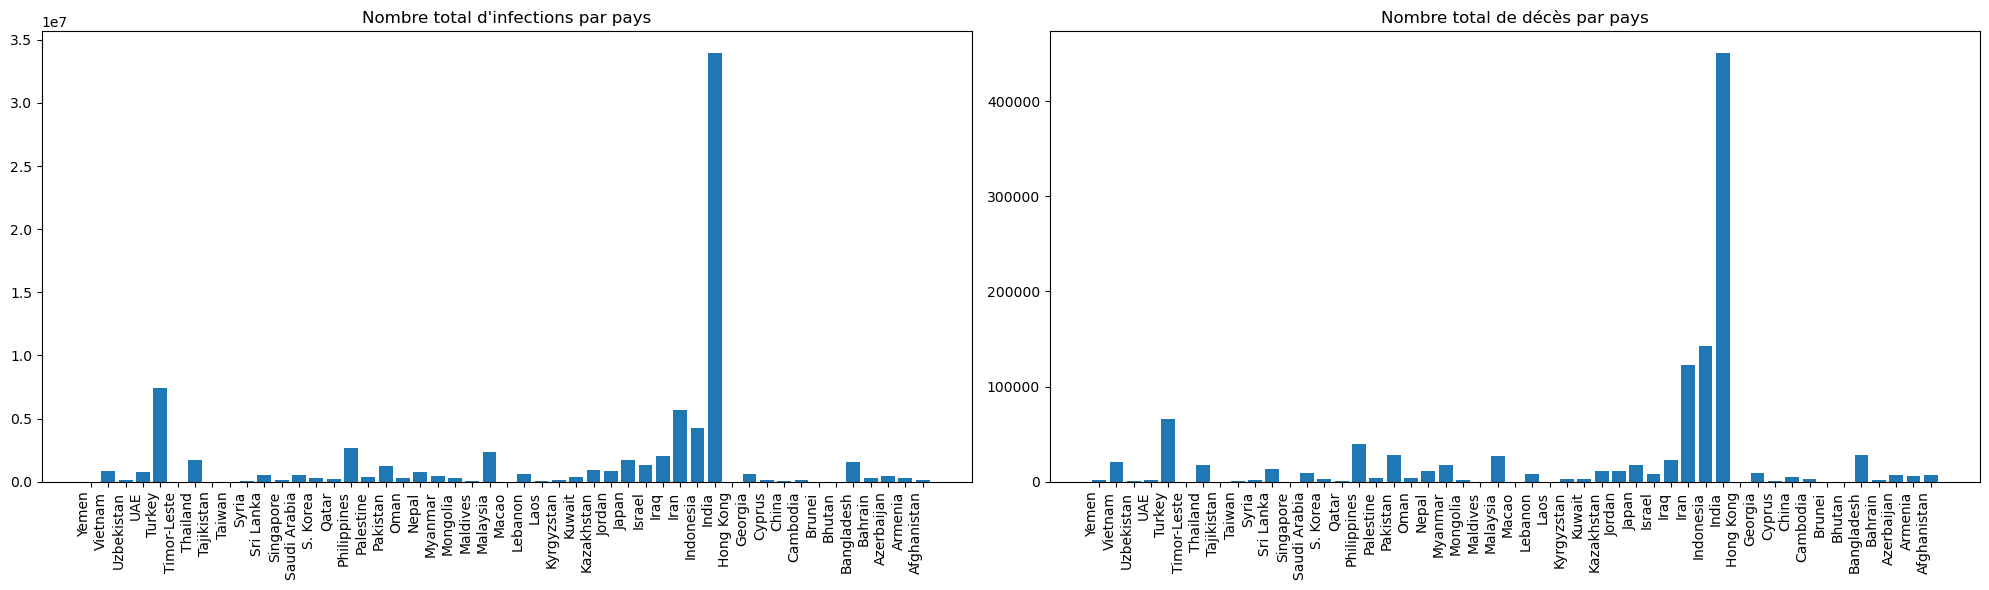

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
plt.bar(data["Country"],data["TotalCases"])
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.title("Nombre total d'infections par pays")

plt.subplot(1,2,2)
plt.bar(data["Country"],data["TotalDeaths"])
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.title("Nombre total de décès par pays")
plt.tight_layout()
plt.show()


Les variables TotalCases, TotalDeaths et TotalRecovered ne sont pas directement utilisables car elles
 pourraient nous conduire à des comparaisons biaisées entre les pays. En effet, ces variables ne tiennent pas
 compte des différences démographiques : un pays très peuplé aura logiquement un nombre total de cas et
 de décès plus élevé qu’un pays avec une petite population, même si l’impact du Covid y est moindre.
 
 C’est pour cette raison que l’utilisation des variables ...PerMillons paraît plus pertinente. Elles permettent
 de relativiser ces différentes statistiques par rapport à la taille de la population du pays considéré, ce qui
 donne une mesure relative et plus équitable de la propagation du virus, des guérisons et de la mortalité.
 La comparaison entre pays va être possible grace à ces variables en tenant compte des disparités de
 population.

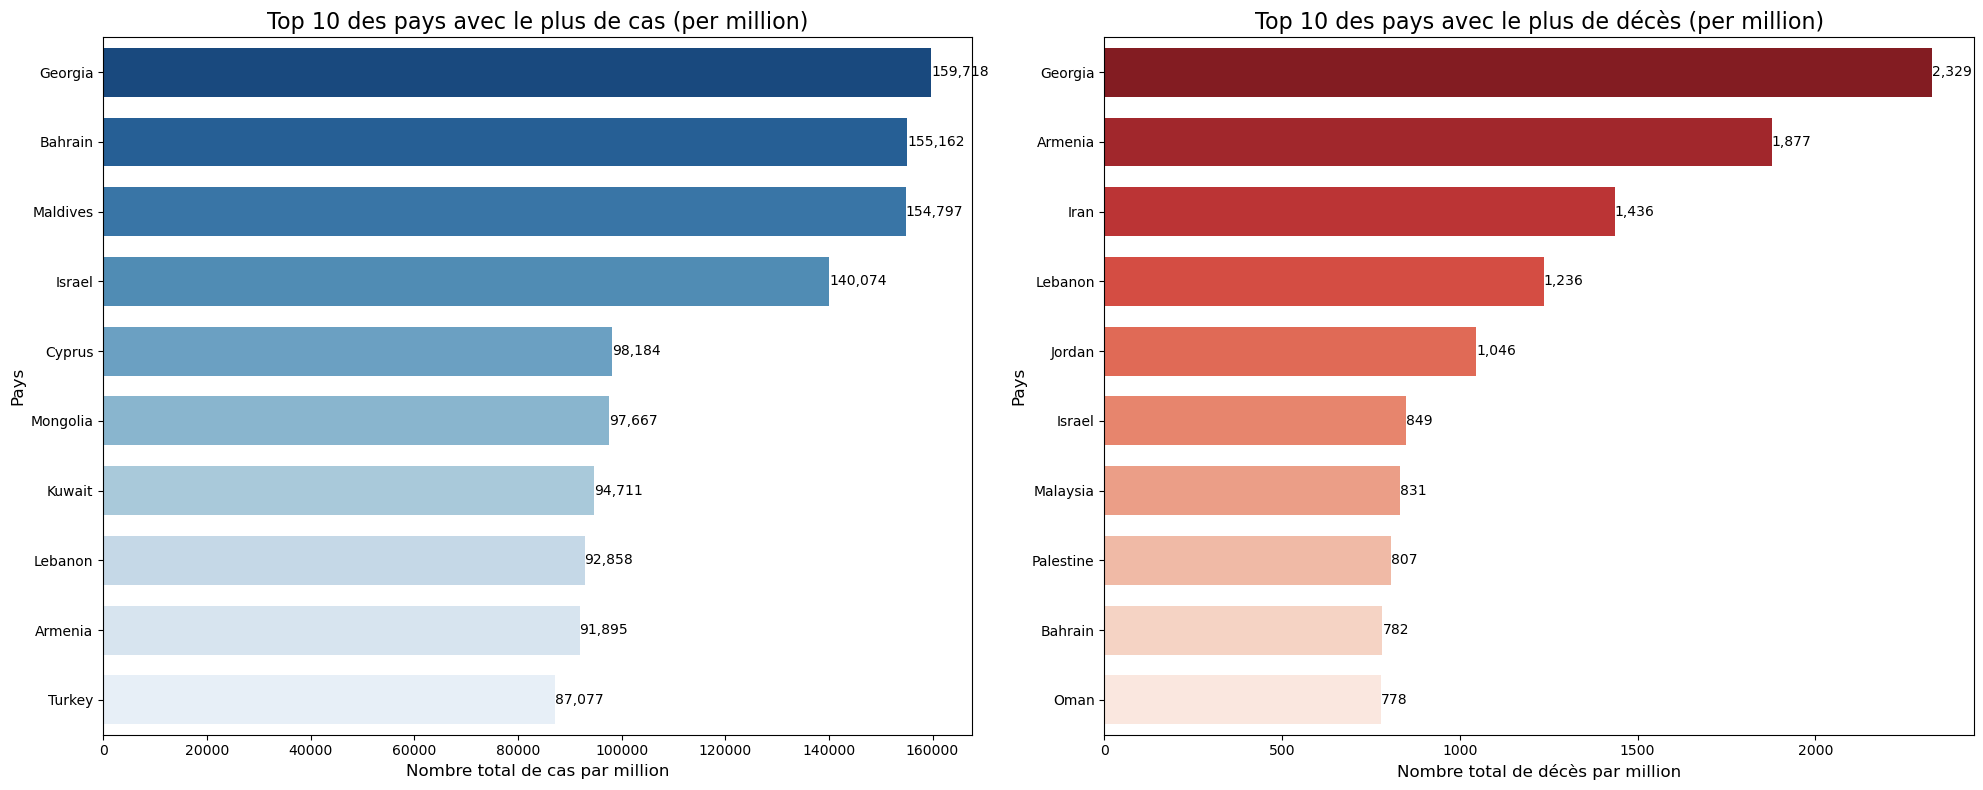

In [ ]:
top_10_cas = data.nlargest(10, "TotalCasesPerMillion")
top_10_deaths = data.nlargest(10, "TotalDeathsPerMillion")

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

colors = sns.color_palette("Blues", len(top_10_cas))
colors_sorted = [colors[i] for i in np.argsort(top_10_cas["TotalCasesPerMillion"])]
ax = sns.barplot(data=top_10_cas, x="TotalCasesPerMillion", y="Country", width=0.7, palette=colors_sorted)
for index, value in enumerate(top_10_cas["TotalCasesPerMillion"]):
    ax.text(value, index, f"{int(value):,}", fontsize=10, color="black", va="center", ha="left")

plt.title("Top 10 des pays avec le plus de cas (per million)", fontsize=16)
plt.xlabel("Nombre total de cas par million", fontsize=12)
plt.ylabel("Pays", fontsize=12)

plt.subplot(1,2,2)

ax = sns.barplot(data=top_10_deaths, x="TotalDeathsPerMillion", y="Country", width=0.7, palette= "Reds_r")

for index, value in enumerate(top_10_deaths["TotalDeathsPerMillion"]):
    ax.text(value, index, f"{int(value):,}", fontsize=10, color="black", va="center", ha="left")

plt.title("Top 10 des pays avec le plus de décès (per million)", fontsize=16)
plt.xlabel("Nombre total de décès par million", fontsize=12)
plt.ylabel("Pays", fontsize=12)
plt.tight_layout()
plt.show()


- Les pays présentant les ratios d’infection les plus élevés sont **Georgia**, **Bahrain**, **Maldives** et **Israel**.  
  Cela signifie que proportionnellement à leur population, ces pays ont enregistré un nombre de cas de Covid par million d’habitants particulièrement élevé. Ces pays ont donc connu une circulation rapide du virus.

- Les pays présentant les ratios de décès les plus élevés sont **Georgia**, **Armenia**, **Iran** et **Lebanon**.  
  Ces pays se distinguent par un nombre élevé de décès rapporté à la taille de leur population. Cela peut être lié à la qualité du système de santé ou encore à la gestion de la crise du Covid.

On crée une nouvelle variable, le nombre de cas guéris par million d’habitants :

$$
\text{TotalRecoveredPerMillion} = \frac{\text{TotalRecovered} \times 10^6}{\text{TotalPopulation}}
$$

In [15]:
data['TotalRecoveredPerMillion'] = (data['TotalRecovered'] * 10**6 / data['TotalPopulation'])

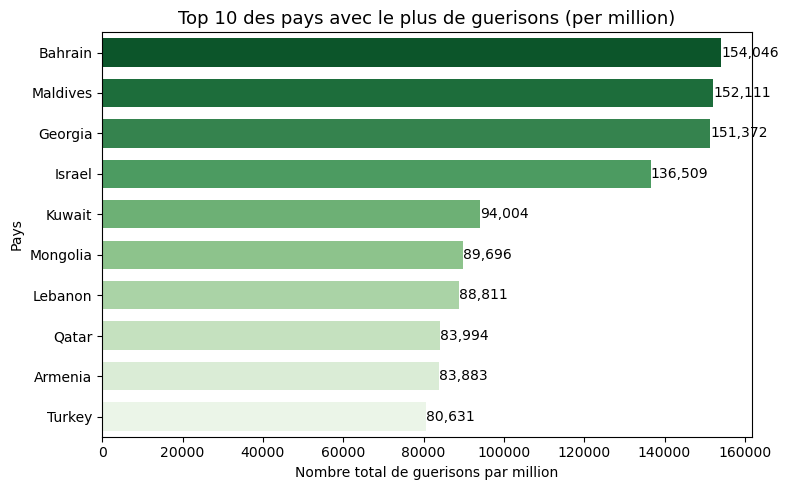

In [ ]:
top_10_recovered = data.nlargest(10, "TotalRecoveredPerMillion")

plt.figure(figsize=(8,5))

colors = sns.color_palette("Greens", len(top_10_cas))
colors_sorted = [colors[i] for i in np.argsort(top_10_recovered["TotalRecoveredPerMillion"])]
ax = sns.barplot(data=top_10_recovered, x="TotalRecoveredPerMillion", y="Country", width=0.7, palette=colors_sorted)
for index, value in enumerate(top_10_recovered["TotalRecoveredPerMillion"]):
    ax.text(value, index, f"{int(value):,}", fontsize=10, color="black", va="center", ha="left")

plt.title("Top 10 des pays avec le plus de guerisons (per million)", fontsize=13)
plt.xlabel("Nombre total de guerisons par million", fontsize=10)
plt.ylabel("Pays", fontsize=10)
plt.tight_layout()
plt.show()

Les pays présentant les ratios de guérison les plus élevés sont
 Bahrain, Maldives, Georgia et Israel. Ces
 pays ont un meilleur système de santé.

### **1.3. Pourcentage de mort, de guérison et de cas actives**

Nous calculons ici les pourcentages de létalité (proportion de décès liés au Covid par rapport au nombre total de cas atteints par le Covid), de guérison et de cas actifs par rapport au nombre total de cas Covid.

- **Pourcentage de létalité (Deaths percent)** :

$$
\text{Deaths percent} = \frac{\text{TotalDeaths}}{\text{TotalCases}} \times 100
$$

- **Pourcentage de cas actifs (ActiveCases percent)** :

$$
\text{ActiveCases percent} = \frac{\text{ActiveCases}}{\text{TotalCases}} \times 100
$$

- **Pourcentage de cas guéris (Recovered percent)** :

$$
\text{Recovered percent} = \frac{\text{TotalRecovered}}{\text{TotalCases}} \times 100
$$

Ces taux permettent de comparer plus précisément l'impact du Covid-19 dans chaque pays, indépendamment du nombre total de cas.


In [17]:
data_mod = data.copy()

In [18]:
data_mod["Deaths_percent"] = (data_mod["TotalDeaths"]/data_mod["TotalCases"])*100
data_mod["ActiveCases_percent"] = (data_mod["ActiveCases"]/data_mod["TotalCases"])*100
data_mod["Recovered_percent"] = (data_mod["TotalRecovered"]/data_mod["TotalCases"])*100

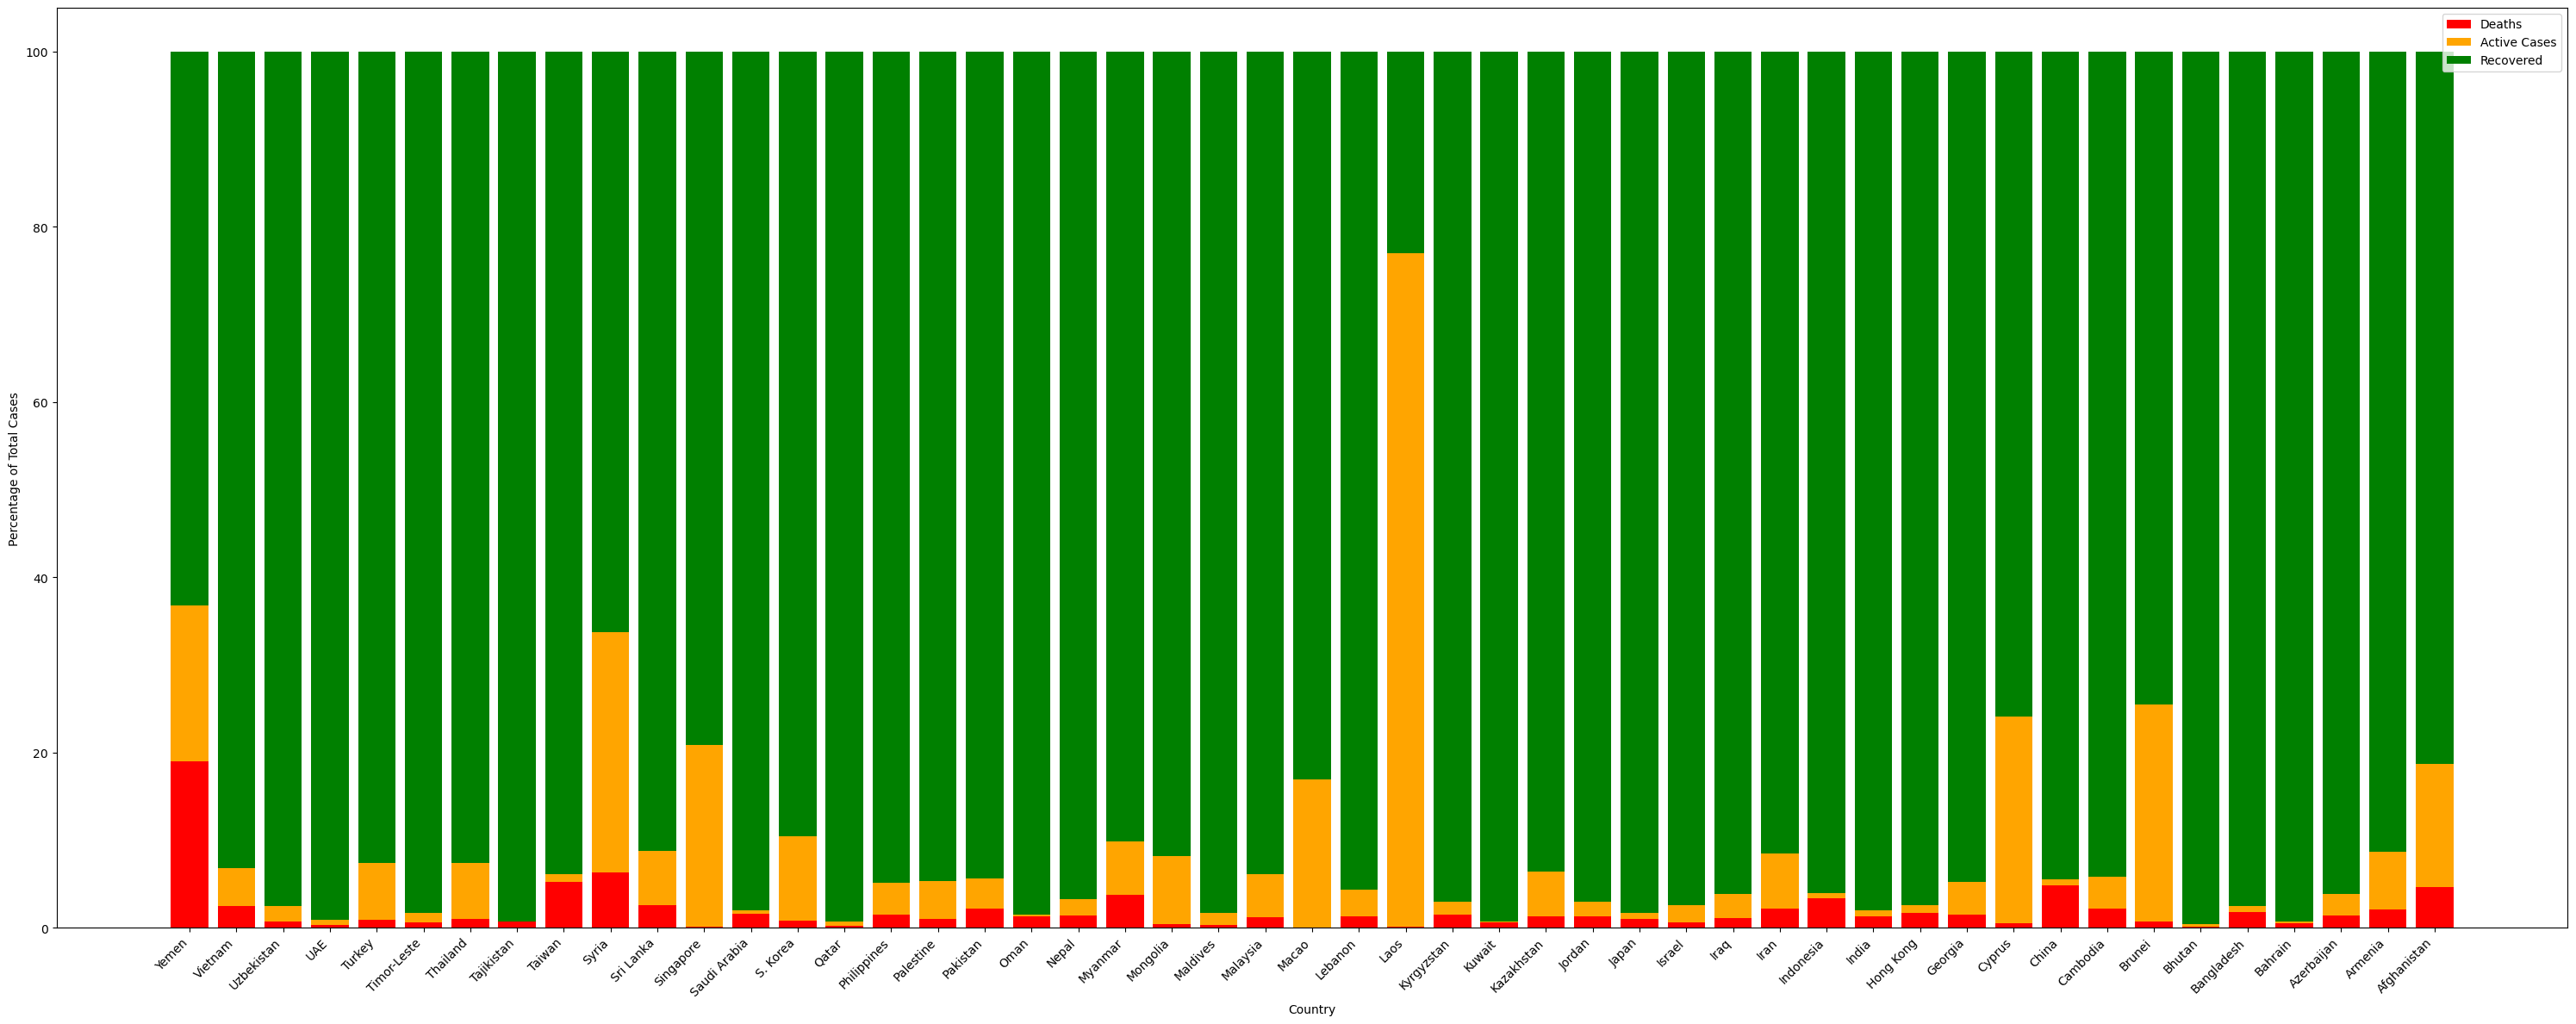

In [ ]:
fig, ax = plt.subplots(figsize=(30, 12))

ax.bar(data_mod['Country'], data_mod['Deaths_percent'], label='Deaths', color='red')
ax.bar(data_mod['Country'], data_mod['ActiveCases_percent'], bottom=data_mod['Deaths_percent'], label='Active Cases', color='orange')
ax.bar(data_mod['Country'], data_mod['Recovered_percent'], bottom=data_mod['Deaths_percent'] + data_mod['ActiveCases_percent'], label='Recovered', color='green')

ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Total Cases')

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Ce graphique met en évidence les décès, cas actifs et cas guéris sur le total des cas dans chaque pays.  
On remarque que :

- **Le Laos** a un taux de guérison bien en dessous des autres pays.  
- **Le Yémen** a le taux de létalité le plus élevé parmi les autres pays.  


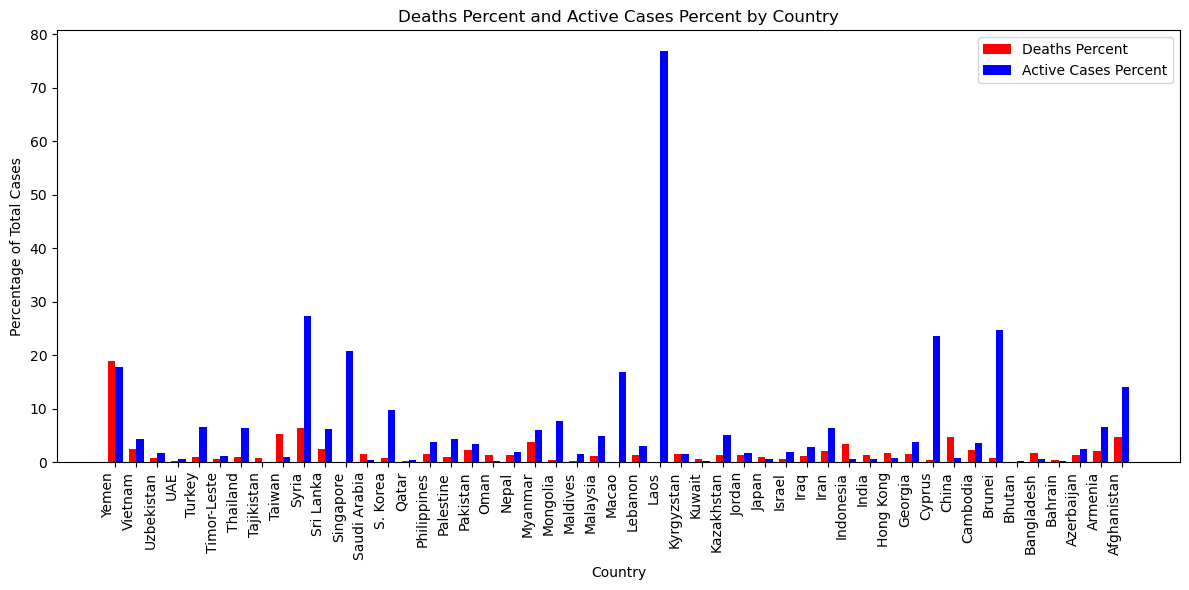

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(data_mod['Country']))
ax.bar(index, data_mod['Deaths_percent'], bar_width, label='Deaths Percent', color='red')
ax.bar(index + bar_width, data_mod['ActiveCases_percent'], bar_width, label='Active Cases Percent', color='blue')

ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Total Cases')
ax.set_title('Deaths Percent and Active Cases Percent by Country')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(data_mod['Country'])

plt.xticks(rotation=90, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

On remarque ici que le Laos est très largement au dessus des autres pays en termes de pourcentage de
 cas actifs (environ 77%).

### **1.4. Matrice de corrélation**


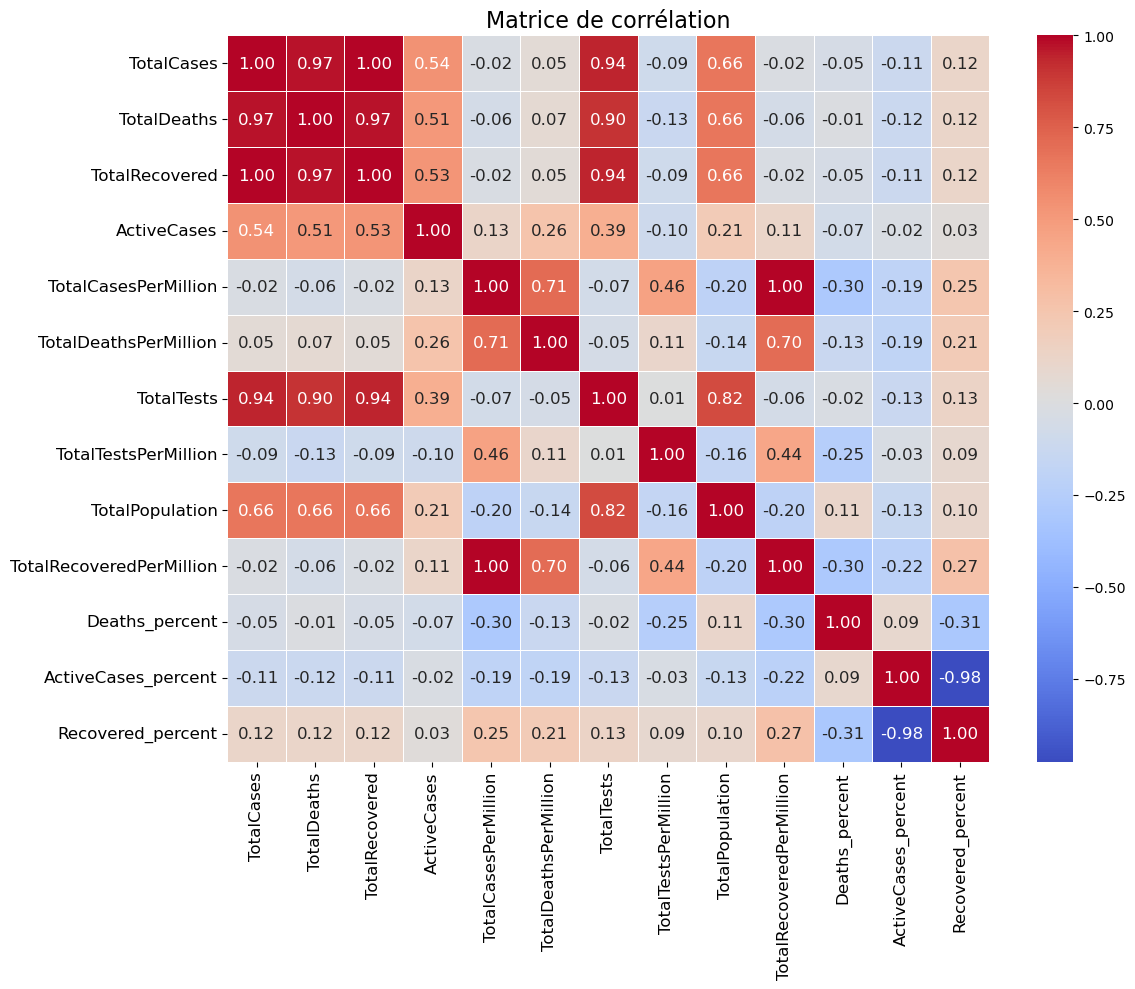

In [ ]:
data1 = data_mod.drop(columns = "Country")
plt.figure(figsize=(12,10))
sns.heatmap(data1.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 12})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Matrice de corrélation",  fontsize = 16)
plt.tight_layout()
plt.show()

La matrice de corrélation met en évidence des corrélations linéaires très fortes entre certaines variables de la base de données.  
On peut notamment observer que :

- Les variables **TotalCases**, **TotalDeaths** et **TotalRecovered** sont fortement corrélées deux à deux.  
- Naturellement, les versions **PerMillion** de ces variables sont également fortement corrélées entre elles.  
- La variable **TotalTests** est très liée à chacune des trois variables **TotalCases**, **TotalDeaths** et **TotalRecovered**.  
- **TotalPopulation** est fortement corrélée à **TotalCases** et **TotalTests**.  
- Les variables **ActiveCases percent** et **Recovered percent** présentent une corrélation presque parfaite.  


## **2. Modélisation**

Notre problématique, telle que définie, consiste à résoudre un problème de clustering et nous utiliserons ici les kmeans pour ce faire.  

**Comment fonctionne l'algorithme des kmeans ?**

Les K-Means sont basés sur la **minimisation de la variance intra-cluster** et ont la réputation d'être simples et rapides.  
L'objectif est de partitionner les données en **K clusters** en minimisant la **somme des distances au carré** entre les points et le centroïde du cluster auquel ils appartiennent.  
Le problème de minimisation s'écrit donc comme ceci :  

$$
J = \sum_{i=1}^{K} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

Avec :  
- $K$ : Nombre de clusters  
- $x$ : Point de données  
- $\mu_i$ : Centroïde du cluster $C_i$  
- $\| x - \mu_i \|^2$ : Distance euclidienne entre le point et le centroïde  

**Étapes de l'algorithme**  
1. Initialisation des $K$ centroïdes (aléatoire ou méthode $k$-means++)  
2. Attribution des points aux clusters les plus proches (en fonction de la distance euclidienne)  
3. Mise à jour des centroïdes en calculant la moyenne des points de chaque cluster  
4. Répétition des étapes 2 et 3 jusqu'à convergence (quand les centroïdes ne bougent plus)

---

La notion de distance, fortement présente dans les k means, est sensible aux données redondantes et aux variations d'échelle entre variables. Ainsi, des variables corrélées risques d'être surreprésentées dans les calculs de distance des K-Means, biaisant ainsi le positionnement des centroïdes. 

Puisque certaines variables de notre base de données présentent des corrélations très fortes, il est pertinent de réduire la dimensionnalité des données en réalisant une **Analyse en Composantes Principales (ACP)**. L'ACP permettrait de synthétiser ces informations en quelques composantes principales et de projeter les données dans un espace réduit (2 ou 3 dimensions), ce qui faciliterait l'interprétation et la visualisation des clusters formés par les K-Means plus tard. 

Nous allons donc appliquer une ACP en amont du clustering, afin d’optimiser la qualité des groupes obtenus et d’améliorer leur visualisation.

### **2.1. L'Analyse en Composantes Principales (ACP)**

Pour réaliser l'ACP, nous avons choisi de supprimer les variables **TotalCases**, **TotalDeaths**, **TotalTests**, **TotalRecovered** et **ActiveCases**. Avec l’analyse exploratoire présentée plus haut, on peut constater que ces variables sont biaisées si elles ne sont pas normalisées (par la population).  
De plus, avec la création de **Deaths_percent**, **Recovery_percent** et **ActiveCase_percent** nous prenons déjà en compte l’information contenue dans ces variables.  

Nous réalisons donc une **ACP** sur les variables suivantes :  
- TotalCasesPerMillion
- TotalDeathsPerMillion 
- TotalTestsPerMillion 
- TotalPopulation
- TotalRecoveredPerMillion 
- Deaths_percent
- ActiveCases_percent
- Recovered_percent 


In [22]:
data_mod1 = data_mod.drop(columns=["TotalCases", "TotalDeaths", "ActiveCases", "TotalTests", "TotalRecovered"])
data_mod1.reset_index(drop=True, inplace=True)

In [23]:
data_mod1.head()

,Country,TotalCasesPerMillion,TotalDeathsPerMillion,TotalTestsPerMillion,TotalPopulation,TotalRecoveredPerMillion,Deaths_percent,ActiveCases_percent,Recovered_percent
0,Yemen,306,58.0,8651.0,30660443,193.115279,18.977479,17.824741,63.197780
1,Vietnam,8529,209.0,431850.0,98453377,7944.867143,2.448009,4.395578,93.156413
2,Uzbekistan,5241,37.0,40425.0,34086135,5110.963739,0.711499,1.765032,97.523469
3,UAE,73477,211.0,8687776.0,10042442,72820.435508,0.286493,0.607272,99.106235
4,Turkey,87077,774.0,1050928.0,85493959,80631.147284,0.888972,6.513434,92.597594


In [24]:
data_for_acp = data_mod1.drop(columns=["Country"])
data_for_acp.head()

,TotalCasesPerMillion,TotalDeathsPerMillion,TotalTestsPerMillion,TotalPopulation,TotalRecoveredPerMillion,Deaths_percent,ActiveCases_percent,Recovered_percent
0,306,58.0,8651.0,30660443,193.115279,18.977479,17.824741,63.197780
1,8529,209.0,431850.0,98453377,7944.867143,2.448009,4.395578,93.156413
2,5241,37.0,40425.0,34086135,5110.963739,0.711499,1.765032,97.523469
3,73477,211.0,8687776.0,10042442,72820.435508,0.286493,0.607272,99.106235
4,87077,774.0,1050928.0,85493959,80631.147284,0.888972,6.513434,92.597594


**ACP et variance expliquée**

In [25]:
# Normalisation des données
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_for_acp)

# L'ACP
pca = PCA()
pca_result = pca.fit_transform(data_normalized)

In [26]:
# Les contributions des variables à chaque axe (composante principale)
contributions = pd.DataFrame(pca.components_, columns=data_for_acp.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# l'inertie (variance expliquée) de chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

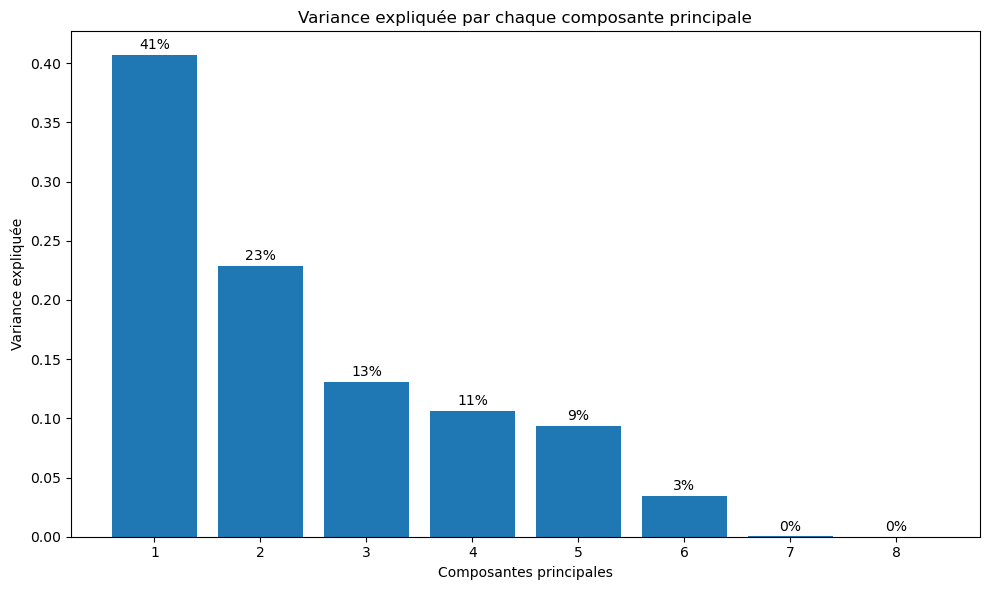

In [ ]:
plt.figure(figsize=(10, 6))
components = range(1, pca.n_components_ + 1)
plt.bar(components, pca.explained_variance_ratio_)
for i, var in zip(components, pca.explained_variance_ratio_):
    plt.text(i, var + 0.005, f'{var:.0%}', ha='center')

plt.title("Variance expliquée par chaque composante principale")
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliquée")
plt.tight_layout()
plt.show()


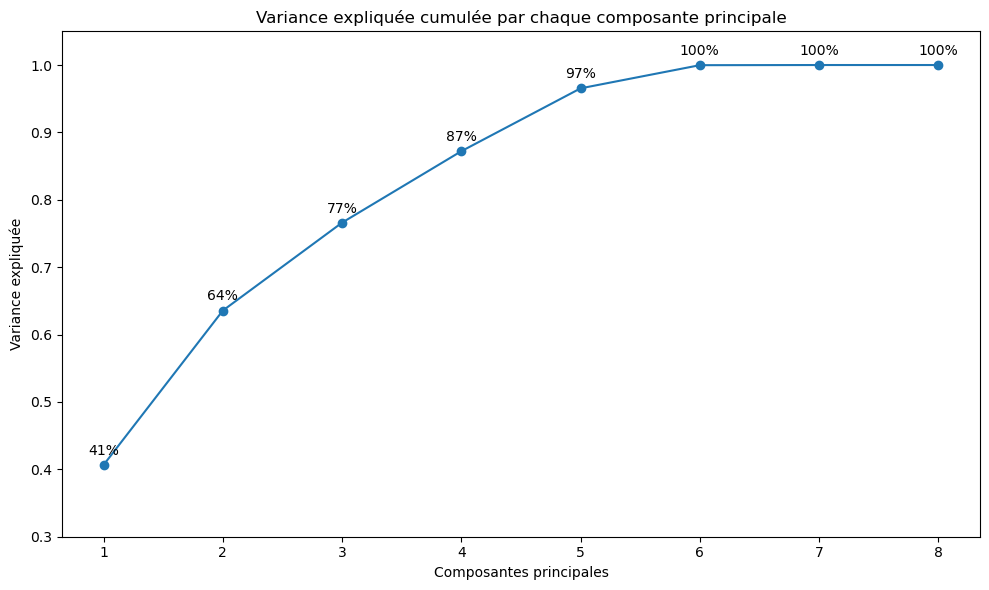

In [ ]:
# Courbe cumulative
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, cumulative_variance, '-o')

for i, var in zip(components, cumulative_variance):
    plt.text(i, var + 0.015, f'{var:.0%}', ha='center')

plt.title("Variance expliquée cumulée par chaque composante principale")
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliquée")
plt.ylim(0.3, 1.05)
plt.tight_layout()
plt.show()


 Nous continuerons l’analyse avec les trois premières composantes principales qui décrivent déjà 77% de la
 variabilité des données.

**Cercle de corrélation**

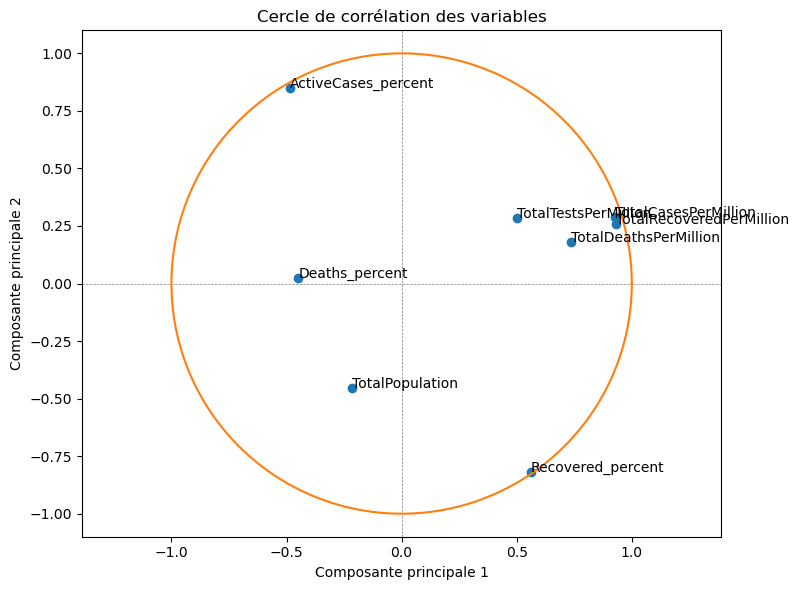

In [ ]:
#Cercle de corrélation
def cercle_correlation(axe1=0, axe2=1):
    plt.figure(figsize=(8,6))
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    racine_lambda_k = np.sqrt(pca.explained_variance_[None, [axe1, axe2]])
    u_kj = pca.components_[[axe1, axe2]].T
    corrs = racine_lambda_k * u_kj
    plt.plot(corrs[:, 0], corrs[:, 1], 'o')
    theta = np.linspace(0, 2*np.pi, 360)
    plt.plot(np.cos(theta), np.sin(theta))
    plt.gca().axis('equal')
    feature_names = getattr(pca, "feature_names_in_", data_for_acp.columns)
    for name, (corr1, corr2) in zip(feature_names, corrs):
        plt.text(corr1, corr2, name, fontsize=10)
cercle_correlation()

plt.title("Cercle de corrélation des variables")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.tight_layout()
plt.show()

**Contributions des variables aux composantes principales**

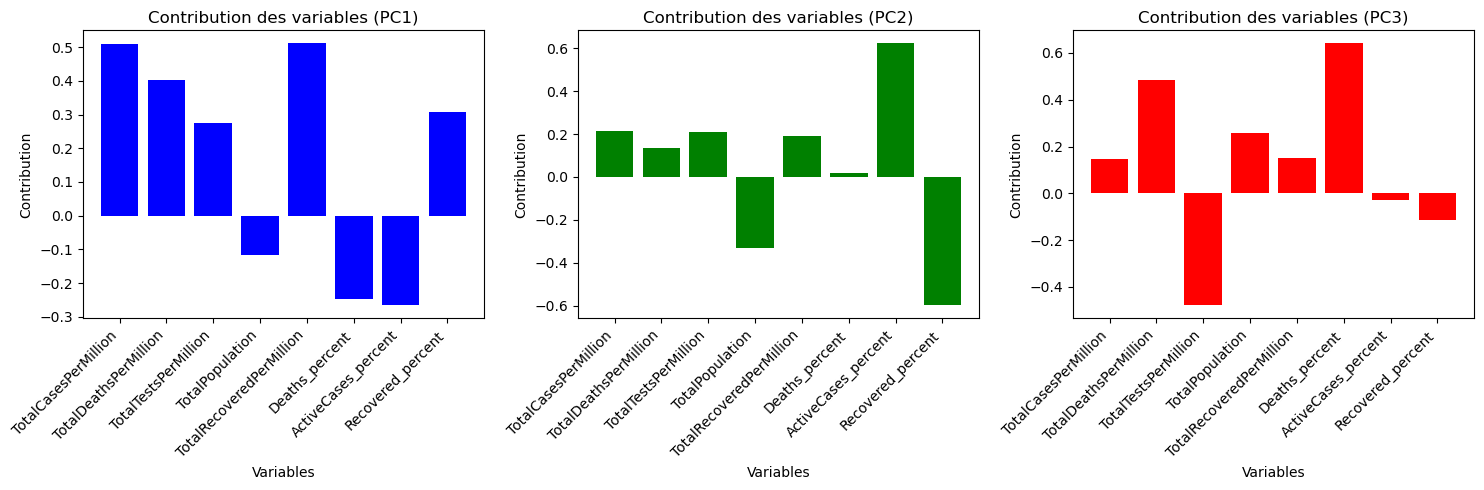

In [ ]:
# Graphique des contributions des variables à la 1ère, 2ème et 3ème composantes principales
plt.figure(figsize=(15, 5))

# Contribution à la première composante principale (PC1)
plt.subplot(1, 3, 1)
plt.bar(data_for_acp.columns, contributions.loc['PC1'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title("Contribution des variables (PC1)")
plt.xlabel("Variables")
plt.ylabel("Contribution")

# Contribution à la deuxième composante principale (PC2)
plt.subplot(1, 3, 2)
plt.bar(data_for_acp.columns, contributions.loc['PC2'], color='green')
plt.xticks(rotation=45, ha='right')
plt.title("Contribution des variables (PC2)")
plt.xlabel("Variables")
plt.ylabel("Contribution")

# Contribution à la troisième composante principale (PC3)
plt.subplot(1, 3, 3)
plt.bar(data_for_acp.columns, contributions.loc['PC3'], color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Contribution des variables (PC3)")
plt.xlabel("Variables")
plt.ylabel("Contribution")

plt.tight_layout()
plt.show()

L’analyse des contributions des variables est un outil important pour interpréter les axes factoriels issus de l’ACP.  
Chaque graphique montre l’importance relative des variables pour chaque composante principale. Les variables avec une grande valeur absolue (positive ou négative) sont les plus importantes.  

- **PC1**  
Pour la première composante, on note que les variables **TotalCasesPerMillion**, **TotalDeathsPerMillion**, **TotalTestsPerMillion**, **TotalRecoveredPerMillion** et **RecoveredPercent** ont de fortes contributions positives. **Deaths percent** et **ActiveCases percent** ont une contribution moyenne négative, indiquant qu’elles sont opposées aux autres variables sur cet axe. Ceci suggère que cette composante est influencée par des indicateurs liés au suivi de la pandémie tels que le nombre total de cas, de tests réalisés, de guérisons et de décès.  

- **PC2**  
Le deuxième axe principal oppose la variable **ActiveCases percent** aux variables **TotalPopulation** et **Recovered percent**. Autrement dit, il oppose la proportion de guérisons à la proportion de cas actifs.  

- **PC3**  
Les variables influentes sur la troisième composante principale (CP) sont **TotalDeathsPerMillion**, **Deaths percent** (contributions positives) et **TotalTestsPerMillion** (contribution négative). Cette composante oppose donc les pays à forte létalité à ceux avec le plus de tests réalisés.  


### **2.2. Les Kmeans**
On réalise maintenant les kmeans sur les trois composantes principales retenues lors de l'ACP.

In [31]:
# L'ACP à 3 CP
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_normalized)

**Méthode du coude et du score de silhouette pour choisir le nombre de clusters optimal**

Les kmeans nécessitent de fixer à priori le nombre k de clusters, ce qui n'est pas toujours évident. Heureusement, des méthodes existent pour faire ce choix : la méthode du coude (Elbow Method) et le score de silhouette.

🔻 **Méthode du coude**

La méthode du coude consiste à représenter l’inertie intra-cluster en fonction du nombre de clusters $K$.

Lorsque $K$ augmente, l’inertie diminue, car les points sont plus proches de leur centroïde. Toutefois, à partir d’un certain point, ajouter des clusters n’apporte plus d'amélioration significative.
Le "coude" de la courbe correspond alors à la valeur de $K$ à partir de laquelle le gain devient négligeable. Il correspond au nombre optimal de clusters.


📏 **Score de silhouette**

Le score de silhouette évalue la cohésion et la séparation des clusters obtenus. Il est défini pour chaque observation et varie entre -1 et 1 :

Un score proche de 1 indique que l’observation est bien assignée à son cluster tandis qu'un score proche de 0 signifie que l’observation est à cheval entre deux clusters.Un score négatif indique, tout simplement, une mauvaise affectation.

On peut calculer la moyenne des scores de silhouette pour chaque valeur de $K$, et retenir celle qui maximise ce score moyen, garantissant des clusters bien séparés et cohérents.

In [32]:
inertia = []
silhouette_scores = []
range_clusters = range(2, 11)  # Essayer de 2 à 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)  # Inertie
    silhouette_scores.append(silhouette_score(data_normalized, kmeans.labels_))  # Score de silhouette

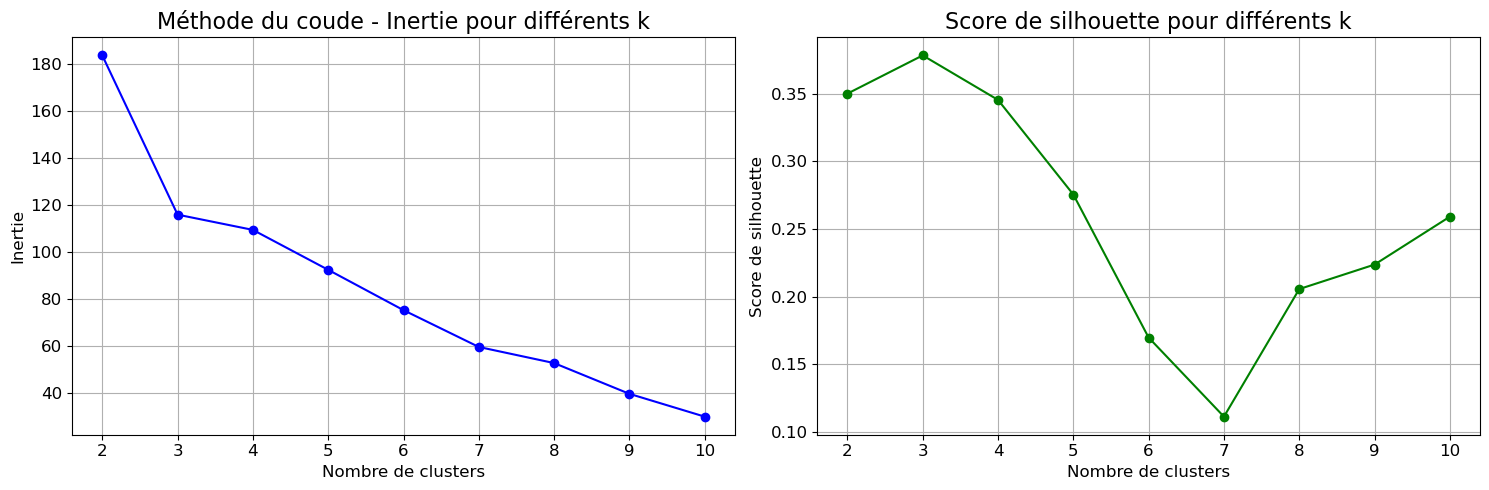

In [ ]:
#La méthode du coude (inertie)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range_clusters, inertia, marker='o', linestyle='-', color='b')
plt.title("Méthode du coude - Inertie pour différents k", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Nombre de clusters", fontsize=12)
plt.ylabel("Inertie", fontsize=12)
plt.grid(True)

#La méthode silouhette
plt.subplot(1, 2, 2)
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title("Score de silhouette pour différents k", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Nombre de clusters", fontsize=12)
plt.ylabel("Score de silhouette", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

La méthode du coude et le graphique du score de silhouette s'accordent sur k = 3 clusters.

**Application des K-means**

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42) 
kmeans.fit(pca_result)

KMeans(n_clusters=3, random_state=42)

**Caractéristiques des clusters**

In [35]:
# Ajouter les labels des clusters au DataFrame
pca_result = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
pca_result["Cluster"] = kmeans.fit_predict(pca_result)
pca_result["Country"] = data_mod['Country'].values

In [36]:
print("Répartition des pays par cluster :")
print(pca_result["Cluster"].value_counts())

Répartition des pays par cluster :
Cluster
1    29
0    17
2     3
Name: count, dtype: int64


In [37]:
df_clusters = pca_result.groupby('Cluster')['Country'].apply(lambda x: ", ".join(x)).reset_index()
df_clusters.columns = ['Cluster', 'Pays']
df_clusters

,Cluster,Pays
0,0,"UAE, Turkey, Qatar, Palestine, Oman, Mongolia,..."
1,1,"Vietnam, Uzbekistan, Timor-Leste, Thailand, Ta..."
2,2,"Yemen, Syria, Laos"


In [38]:
print("Les 17 pays du premier cluster sont: ")
print(df_clusters.loc[0, "Pays"])

print("\nLes 29 pays du deuxième cluster sont: ")
print(df_clusters.loc[1, "Pays"])

print("\nLes 3 pays du troisième cluster sont: ")
print(df_clusters.loc[2, "Pays"])

Les 17 pays du premier cluster sont: 
UAE, Turkey, Qatar, Palestine, Oman, Mongolia, Maldives, Malaysia, Lebanon, Kuwait, Jordan, Israel, Iran, Georgia, Cyprus, Bahrain, Armenia

Les 29 pays du deuxième cluster sont: 
Vietnam, Uzbekistan, Timor-Leste, Thailand, Tajikistan, Taiwan, Sri Lanka, Singapore, Saudi Arabia, S. Korea, Philippines, Pakistan, Nepal, Myanmar, Macao, Kyrgyzstan, Kazakhstan, Japan, Iraq, Indonesia, India, Hong Kong, China, Cambodia, Brunei, Bhutan, Bangladesh, Azerbaijan, Afghanistan

Les 3 pays du troisième cluster sont: 
Yemen, Syria, Laos


**Comment comprendre ces clusters ?**

Les coordonnées moyennes (centroïdes) des clusters sur les trois premières composantes de l’ACP fournissent des informations pour mieux comprendre les caractéristiques de chaque groupe de pays.

In [39]:
centroides = pca_result.groupby('Cluster')[['PC1', 'PC2', 'PC3']].mean().reset_index()
centroides = pd.DataFrame(centroides)
centroides = centroides.rename(columns={"PC1": "Centroid_PC1", "PC2": "Centroid_PC2", "PC3": "Centroid_PC3"})
cendroides = centroides.set_index("Cluster")
cendroides

,Centroid_PC1,Centroid_PC2,Centroid_PC3
Cluster,,,
0,2.039470,0.539671,0.153684
1,-0.814863,-0.641324,-0.228999
2,-3.679988,3.141335,1.342775


On peut noter : 

- **Cluster 0**

Le centre de gravité du Cluster 0, de coordonnées (2.04, 0.54, 0.15), indique que ces pays sont caractérisés par des valeurs élevées des variables TotalCasesPerMillion, TotalDeathsPerMillion, TotalTestsPerMillion, TotalRecoveredPerMillion, Recovered percent (PC1) et par une proportion modérée de cas actifs (PC2).  
*Ce cluster regroupe donc des pays très exposés, avec une proportion modérée de cas actifs mais qui parviennent à bien gérer la crise.*

- **Cluster 1** 

Les pays de ce cluster seraient caractérisés par des valeurs faibles de TotalCasesPerMillion, TotalDeathsPerMillion, TotalTestsPerMillion, TotalRecoveredPerMillion, Recovered percent (PC1), avec plus de cas guéris que de cas actifs et légèrement plus de tests réalisés que de décès.
*Ce cluster regroupe donc des pays avec une exposition bien suivie et contrôlée à la pandémie du Covid, avec un bon taux de guérison.* 

- **Cluster 2**

Le Yémen, la Syrie et le Laos sont des pays avec de très faibles nombres de cas totaux, de tests réalisés et de guérisons (PC1). Ils réalisent peu de tests (PC3), ont beaucoup de cas actifs (PC2) et de décès (PC3), et par ricochet peu de cas guéris (PC2).   
*Ces trois pays représentent donc des pays à situation critique et nécessitent une action rapide.* 


**Visualisation en 3D**

Grâce à l'ACP nous pouvons visualiser nos clusters. 

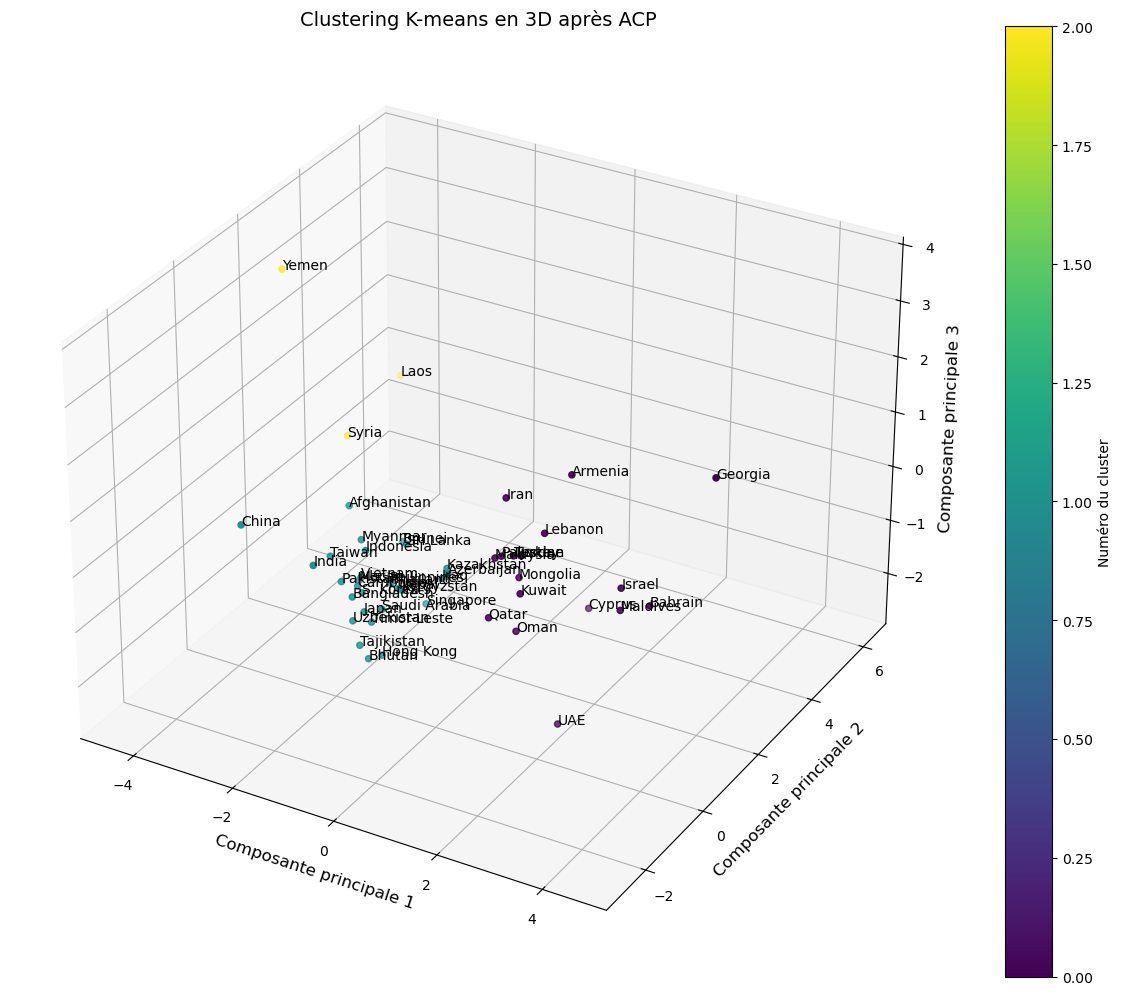

In [ ]:
# Ajouter les labels des clusters au DataFrame
pca_result = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
pca_result["Cluster"] = kmeans.fit_predict(pca_result)
pca_result["Country"] = data_mod['Country'].values

# Visualisation 3D des clusters K-means
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result["PC1"], pca_result["PC2"], pca_result["PC3"], c=pca_result["Cluster"], cmap='viridis')

# Légendes
ax.set_xlabel('Composante principale 1', fontsize=12)
ax.set_ylabel('Composante principale 2', fontsize=12)
ax.set_zlabel('Composante principale 3', fontsize=12)
ax.set_title('Clustering K-means en 3D après ACP', fontsize=14)

# Barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Numéro du cluster')

#Affichage des noms des pays
for i in range(len(pca_result)):
    ax.text(pca_result["PC1"].iloc[i], pca_result["PC2"].iloc[i], pca_result["PC3"].iloc[i], pca_result["Country"].iloc[i], size=10)

plt.tight_layout()
plt.show()

## **Conclusion**

Grâce à cette étude, nous avons pu dégager des types de pays asiatiques différents en termes de gestion de la pandémie du Covid-19.  

L'approche robuste **ACP + K-means** s'est révélée particulièrement pertinente. Elle sépare :  

- les pays fortement exposés, ayant une proportion modérée de cas actifs et qui parviennent à bien gérer la crise tels que la Géorgie, le Qatar, les Maldives, Chypre, la Malaisie, le Liban, ...  
- les pays avec une exposition bien suivie et maîtrisée de la pandémie du Covid tels que l’Afghanistan, l’Arabie saoudite, la Chine, le Viêt Nam ...  
- le Yémen, le Laos et la Syrie, des pays en difficultés, ayant besoin d’attention urgente.  

Ces résultats fournissent un outil d’aide à la décision concret pour l’OMS, permettant de mieux cibler ses interventions et d’orienter efficacement les ressources vers les pays qui en ont le plus besoin.
